In [ ]:
import numpy as np
from scipy.linalg import sqrtm
from scipy.stats import kendalltau
from scipy.stats import pearsonr
from scipy.stats  import spearmanr
from numpy.linalg import norm
from scipy.stats import wishart
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
from sklearn.covariance import OAS

def array_to_latex_table(arr, row_labels=None):
    rows, cols = arr.shape
    latex_table = "\\begin{tabular}{" + "l" + "c" * cols + "}\n"  # 'l' for left-aligned row labels

    # Add row labels if provided
    if row_labels is not None:
        if len(row_labels) != rows:
            raise ValueError("The number of row labels must match the number of rows in the array.")

    for i, row in enumerate(arr):
        label = row_labels[i] if row_labels else ""
        latex_table += label + " & " + " & ".join(map(str, row)) + " \\\\\n"

    latex_table += "\\end{tabular}"
    return latex_table

print (array_to_latex_table(np.array([[1,2],[3,4]]),['b','a']))

\begin{tabular}{lcc}
b & 1 & 2 \\
a & 3 & 4 \\
\end{tabular}


In [ ]:
d = 10
#r = 10
#A = np.random.randn(d, r)
#sigma_true = A @ A.T  #+ 0.1*np.eye(d)
sigma_true = np.eye(d)
sigma_true[0,0] = 100
sqrt_sigma_true = sqrtm(sigma_true)

def kl(sigma_true, sigma_est):
    d = sigma_true.shape[0]
    inv_sigma_est = np.linalg.inv(sigma_est)
    trace_term = np.trace(inv_sigma_est @ sigma_true)
    log_det_term = np.log(np.linalg.det(sigma_est) / np.linalg.det(sigma_true))
    return (trace_term - d + log_det_term)

def symkl(sigma_true, sigma_est):
    d = sigma_true.shape[0]
    sqrtinvest = sqrtm(np.linalg.inv(sigma_est))
    Q = sqrtinvest @ sigma_true @ sqrtinvest.T
    return (np.trace(Q) + np.trace(np.linalg.inv(Q)) - 2*d)

def mseq(sigma_true, sigma_est):
    d = sigma_true.shape[0]
    sqrtinvest = sqrtm(np.linalg.inv(sigma_est))
    Q = sqrtinvest @ sigma_true @ sqrtinvest.T
    return norm(Q - np.eye(d), 'fro')

def nsnr(sigma_true, sigma_est):
    sqrtinvest = sqrtm(np.linalg.inv(sigma_est))
    Q = sqrtinvest @ sigma_true @ sqrtinvest.T
    eigQ = np.linalg.eigh(Q)[0]
    qmax = np.max(eigQ)
    qmin = np.min(eigQ)
    cond = qmax/qmin + 1e-6
    return np.log((cond+1)**2/4/cond)

n_list = np.arange(50,201,50)
num_n = len(n_list)
num_experiments = 1000
frob_errors = np.zeros((num_experiments,num_n))
mseq_errors = np.zeros((num_experiments,num_n))
op_errors = np.zeros((num_experiments,num_n))
kl_errors = np.zeros((num_experiments,num_n))
symkl_errors = np.zeros((num_experiments,num_n))
nsnr_errors = np.zeros((num_experiments,num_n))
tau_frob = np.zeros((num_n))
tau_mseq = np.zeros((num_n))
tau_kl = np.zeros((num_n))
tau_symkl = np.zeros((num_n))
tau_op = np.zeros((num_n))
pr_frob = np.zeros((num_n))
pr_mseq = np.zeros((num_n))
pr_kl = np.zeros((num_n))
pr_symkl = np.zeros((num_n))
pr_op = np.zeros((num_n))
for j in range(num_n):
  n = n_list[j]
  for i in range(num_experiments):
      samples = np.random.multivariate_normal(np.zeros(d), sigma_true, n)
      #sigma_est = np.cov(samples, rowvar=False) + 0.0 * np.eye(d)
      sigma_est = LedoitWolf(assume_centered=True).fit(samples).covariance_

      # Compute the errors
      frob_errors[i,j] = norm(sigma_true - sigma_est, 'fro')
      mseq_errors[i,j] = mseq(sigma_true, sigma_est)
      op_errors[i,j] = norm(sigma_est - sigma_true, 2)
      kl_errors[i,j] = kl(sigma_true, sigma_est)
      symkl_errors[i,j] = symkl(sigma_true, sigma_est)
      nsnr_errors[i,j] = nsnr(sigma_true, sigma_est)

  # Calculate correlations of different metrics with respect to nsnr
  corr = pearsonr
  pr_frob[j], _ = corr(frob_errors[:,j], nsnr_errors[:,j])
  pr_mseq[j], _ = corr(mseq_errors[:,j], nsnr_errors[:,j])
  pr_kl[j], _ = corr(kl_errors[:,j], nsnr_errors[:,j])
  pr_symkl[j], _ = corr(symkl_errors[:,j], nsnr_errors[:,j])
  pr_op[j], _ = corr(op_errors[:,j], nsnr_errors[:,j])

  corr = kendalltau
  tau_frob[j], _ = corr(frob_errors[:,j], nsnr_errors[:,j])
  tau_mseq[j], _ = corr(mseq_errors[:,j], nsnr_errors[:,j])
  tau_kl[j], _ = corr(kl_errors[:,j], nsnr_errors[:,j])
  tau_symkl[j], _ = corr(symkl_errors[:,j], nsnr_errors[:,j])
  tau_op[j], _ = corr(op_errors[:,j], nsnr_errors[:,j])

# Print results
print("Pearson:")
print(f"Frobenius:        {np.round(pr_frob,2)}")
#print(f"MSE in Q:         {np.round(pr_mseq,2)}")
print(f"KL divergence:    {np.round(pr_kl,2)}")
print(f"symKL divergence: {np.round(pr_symkl,2)}")
print(f"Operator Norm:    {np.round(pr_op,2)}")
print("KendallTau:")
print(f"Frobenius:        {np.round(tau_frob,2)}")
#print(f"MSE in Q:         {np.round(tau_mseq,2)}")
print(f"KL divergence:    {np.round(tau_kl,2)}")
print(f"symKL divergence: {np.round(tau_symkl,2)}")
print(f"Operator Norm:    {np.round(tau_op,2)}")


Pearson:
Frobenius:        [0.28 0.23 0.18 0.16]
KL divergence:    [0.19 0.54 0.64 0.77]
symKL divergence: [0.04 0.38 0.52 0.7 ]
Operator Norm:    [0.28 0.23 0.18 0.16]
KendallTau:
Frobenius:        [0.21 0.17 0.12 0.1 ]
KL divergence:    [0.2  0.39 0.47 0.56]
symKL divergence: [0.09 0.28 0.38 0.51]
Operator Norm:    [0.19 0.16 0.11 0.09]


In [ ]:
pearson_results = np.array([[np.round(pr_frob,2),np.round(pr_op,2),np.round(pr_kl,2),np.round(pr_symkl,2)]])
print(array_to_latex_table(pearson_results[0],["Frobenius","Operator Norm","KL","symKL"]))
kendall_results = np.array([[np.round(tau_frob,2),np.round(pr_op,2),np.round(pr_kl,2),np.round(pr_symkl,2)]])
print(array_to_latex_table(kendall_results[0],["Frobenius","Operator Norm","KL","symKL"]))

\begin{tabular}{lcccc}
Frobenius & 0.1 & 0.08 & 0.12 & 0.17 \\
Operator Norm & 0.09 & 0.07 & 0.11 & 0.17 \\
KL & 0.82 & 0.84 & 0.81 & 0.83 \\
symKL & 0.85 & 0.87 & 0.84 & 0.85 \\
\end{tabular}
\begin{tabular}{lcccc}
Frobenius & 0.06 & 0.05 & 0.06 & 0.11 \\
Operator Norm & 0.09 & 0.07 & 0.11 & 0.17 \\
KL & 0.82 & 0.84 & 0.81 & 0.83 \\
symKL & 0.85 & 0.87 & 0.84 & 0.85 \\
\end{tabular}


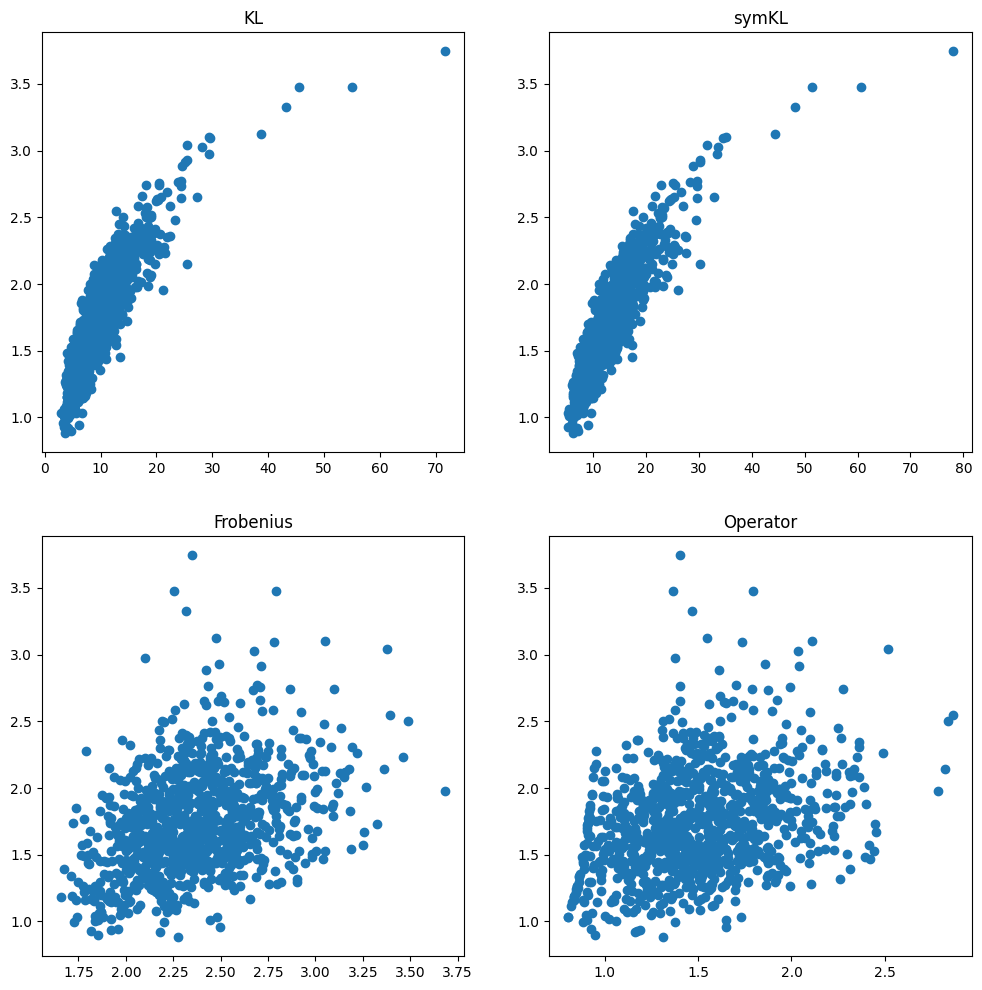

In [ ]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

ax0.scatter(kl_errors[:,0],nsnr_errors[:,0])
ax0.set_title("KL")

ax1.scatter(symkl_errors[:,0],nsnr_errors[:,0])
ax1.set_title("symKL")

ax2.scatter(frob_errors[:,0],nsnr_errors[:,0])
ax2.set_title("Frobenius")

ax3.scatter(op_errors[:,0],nsnr_errors[:,0])
ax3.set_title("Operator")
plt.show()

In [ ]:
d = 10
#r = 10
#A = np.random.randn(d, r)
#sigma_true = A @ A.T  #+ 0.1*np.eye(d)
sigma_true = np.eye(d)
sigma_true[0,0] = 100
sqrt_sigma_true = sqrtm(sigma_true)


n_list = np.array([0.01,0.1,-1])
num_n = len(n_list)
num_experiments = 1000
frob_errors = np.zeros((num_experiments,num_n))
mseq_errors = np.zeros((num_experiments,num_n))
op_errors = np.zeros((num_experiments,num_n))
kl_errors = np.zeros((num_experiments,num_n))
symkl_errors = np.zeros((num_experiments,num_n))
nsnr_errors = np.zeros((num_experiments,num_n))
tau_frob = np.zeros((num_n))
tau_mseq = np.zeros((num_n))
tau_kl = np.zeros((num_n))
tau_symkl = np.zeros((num_n))
tau_op = np.zeros((num_n))
pr_frob = np.zeros((num_n))
pr_mseq = np.zeros((num_n))
pr_kl = np.zeros((num_n))
pr_symkl = np.zeros((num_n))
pr_op = np.zeros((num_n))
for j in range(num_n):
  n = 200
  reg = n_list[j]
  for i in range(num_experiments):
      samples = np.random.multivariate_normal(np.zeros(d), sigma_true, n)
      if reg>0:
        sigma_est = np.cov(samples, rowvar=False) + reg * np.eye(d)
      else:
        sigma_est = LedoitWolf(assume_centered=True).fit(samples).covariance_

      # Compute the errors
      frob_errors[i,j] = norm(sigma_true - sigma_est, 'fro')
      mseq_errors[i,j] = mseq(sigma_true, sigma_est)
      op_errors[i,j] = norm(sigma_est - sigma_true, 2)
      kl_errors[i,j] = kl(sigma_true, sigma_est)
      symkl_errors[i,j] = symkl(sigma_true, sigma_est)
      nsnr_errors[i,j] = nsnr(sigma_true, sigma_est)

  # Calculate correlations of different metrics with respect to nsnr
  corr = pearsonr
  pr_frob[j], _ = corr(frob_errors[:,j], nsnr_errors[:,j])
  pr_mseq[j], _ = corr(mseq_errors[:,j], nsnr_errors[:,j])
  pr_kl[j], _ = corr(kl_errors[:,j], nsnr_errors[:,j])
  pr_symkl[j], _ = corr(symkl_errors[:,j], nsnr_errors[:,j])
  pr_op[j], _ = corr(op_errors[:,j], nsnr_errors[:,j])

  corr = kendalltau
  tau_frob[j], _ = corr(frob_errors[:,j], nsnr_errors[:,j])
  tau_mseq[j], _ = corr(mseq_errors[:,j], nsnr_errors[:,j])
  tau_kl[j], _ = corr(kl_errors[:,j], nsnr_errors[:,j])
  tau_symkl[j], _ = corr(symkl_errors[:,j], nsnr_errors[:,j])
  tau_op[j], _ = corr(op_errors[:,j], nsnr_errors[:,j])

# Print results
print("Pearson:")
print(f"Frobenius:        {np.round(pr_frob,2)}")
#print(f"MSE in Q:         {np.round(pr_mseq,2)}")
print(f"KL divergence:    {np.round(pr_kl,2)}")
print(f"symKL divergence: {np.round(pr_symkl,2)}")
print(f"Operator Norm:    {np.round(pr_op,2)}")
print("KendallTau:")
print(f"Frobenius:        {np.round(tau_frob,2)}")
#print(f"MSE in Q:         {np.round(tau_mseq,2)}")
print(f"KL divergence:    {np.round(tau_kl,2)}")
print(f"symKL divergence: {np.round(tau_symkl,2)}")
print(f"Operator Norm:    {np.round(tau_op,2)}")


Pearson:
Frobenius:        [0.1  0.25 0.2 ]
KL divergence:    [0.83 0.85 0.76]
symKL divergence: [0.85 0.81 0.68]
Operator Norm:    [0.09 0.24 0.2 ]
KendallTau:
Frobenius:        [0.06 0.16 0.13]
KL divergence:    [0.64 0.65 0.54]
symKL divergence: [0.66 0.61 0.47]
Operator Norm:    [0.06 0.15 0.12]


In [ ]:
print (np.mean(nsnr_errors,axis=0))
print (np.mean(kl_errors,axis=0))
print (np.mean(frob_errors,axis=0))
print (np.mean(op_errors,axis=0))

[0.14122341 0.1227855  0.11796879]
[0.29209914 0.24930976 0.24995533]
[8.80640998 8.86119362 8.89486152]
[8.65456964 8.69715709 8.73445309]


In [ ]:
pearson_results = np.array([[np.round(pr_frob,2),np.round(pr_op,2),np.round(pr_kl,2),np.round(pr_symkl,2)]])
print(array_to_latex_table(pearson_results[0],["Frobenius","Operator Norm","KL","symKL"]))

\begin{tabular}{lccc}
Frobenius & 0.1 & 0.25 & 0.2 \\
Operator Norm & 0.09 & 0.24 & 0.2 \\
KL & 0.83 & 0.85 & 0.76 \\
symKL & 0.85 & 0.81 & 0.68 \\
\end{tabular}
